In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, cross_val_score

#LOAD DATASETS
train_features = pd.read_csv('./data/derived/feature_selection/training_data_with_dual.csv')
test_features = pd.read_csv('./data/derived/feature_selection/test_data_with_dual.csv')
#combine train and test datasets
combined = pd.concat([train_features, test_features])

In [121]:
#DEFINE RECENCY
years = 1
recency_threshold = (years*12) * 30.44

features = [
    'genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c',
    'gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig',
    'pol_ambig', 'gp41_ambig', 'gp120_ambig'
]
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig', 
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                    'gp41_maf12c', 'gp41_maf3c', 'gp41_ambig']


features_tanya = ['gag_lrtt', 'gp120_lrtt', 'pol_lrtt',
                  'gp41_tips', 'gag_tips', 'gp120_tips',
                  'gp41_maf12c',
                  'gag_maf3c', 'gp41_maf3c']

# Label the data
train_features['recency'] = np.where(train_features['TSI_days'] <= recency_threshold, 1, 0)
test_features['recency'] = np.where(test_features['TSI_days'] <= recency_threshold, 1, 0)
combined['recency'] = np.where(combined['TSI_days'] <= recency_threshold, 1, 0)

In [ ]:

# Features and target variable for training and testing sets
X_train = train_features[features_derived]
y_train = train_features['recency']
X_test = test_features[features_derived]
y_test = test_features['recency']

# 1- HYPER PARAMETER TUNING

In [102]:
#define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
#define grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

#fit grid search on training data
grid_search.fit(X_train, y_train)

In [ ]:
best_model = grid_search.best_estimator_

#make predictions
y_pred = best_model.predict(X_test)

#evaluate
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# 2 - BINARY CLASSIFIER WITH TUNED PARAMETERS

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        67
           1       0.77      0.82      0.80        88

    accuracy                           0.76       155
   macro avg       0.76      0.75      0.75       155
weighted avg       0.76      0.76      0.76       155


Additional Performance Metrics:
Accuracy: 0.7613
ROC AUC: 0.8506
Average Precision: 0.8843
Precision (Non-Recent): 0.7419
Recall (Non-Recent): 0.6866
F1-Score (Non-Recent): 0.7132
Precision (Recent): 0.7742
Recall (Recent): 0.8182
F1-Score (Recent): 0.7956


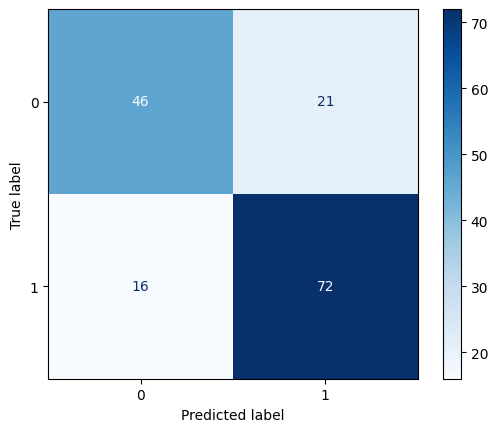

In [113]:
# Perform predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
# Calculate additional performance metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Calculate precision, recall, and f1-score for positive and negative classes
precision_non_recent = precision_score(y_test, y_pred, pos_label=0)
recall_non_recent = recall_score(y_test, y_pred, pos_label=0)
f1_non_recent = f1_score(y_test, y_pred, pos_label=0)

precision_recent = precision_score(y_test, y_pred, pos_label=1)
recall_recent = recall_score(y_test, y_pred, pos_label=1)
f1_recent = f1_score(y_test, y_pred, pos_label=1)

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)
print("\nAdditional Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Precision (Non-Recent): {precision_non_recent:.4f}")
print(f"Recall (Non-Recent): {recall_non_recent:.4f}")
print(f"F1-Score (Non-Recent): {f1_non_recent:.4f}")
print(f"Precision (Recent): {precision_recent:.4f}")
print(f"Recall (Recent): {recall_recent:.4f}")
print(f"F1-Score (Recent): {f1_recent:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## side plot

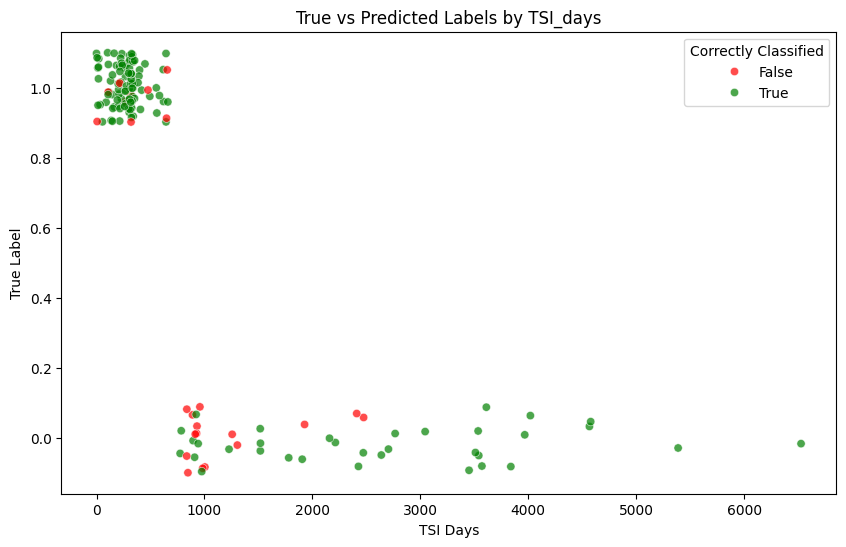

In [8]:
# Create a DataFrame with true and predicted labels, and TSI_days
results_df = test_features[['TSI_days']].copy()
results_df['True Label'] = y_test
results_df['Predicted Label'] = y_pred
results_df['Correctly Classified'] = results_df['True Label'] == results_df['Predicted Label']

# Offset true labels slightly for better visualization
results_df['True Label Offset'] = results_df['True Label'] + np.random.uniform(-0.1, 0.1, size=results_df.shape[0])

# Plot the correctly and incorrectly classified samples against TSI_days
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='TSI_days', y='True Label Offset', hue='Correctly Classified', palette=['red', 'green'], alpha=0.7)
plt.title('True vs Predicted Labels by TSI_days')
plt.xlabel('TSI Days')
plt.ylabel('True Label')
plt.legend(title='Correctly Classified')
plt.show()

# 3 - LOOCV

In [ ]:
# Initialize the model with the best parameters
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Features and target variable for the combined dataset
X = combined[features_derived]
y = combined['recency']

# Perform LOOCV
loo = LeaveOneOut()
loo_scores = cross_val_score(best_rf_model, X, y, cv=loo, scoring='accuracy', n_jobs=-1)

# Calculate the mean accuracy and confidence interval
mean_accuracy = np.mean(loo_scores)
conf_interval = np.percentile(loo_scores, [2.5, 97.5])

print(f"LOOCV Mean Accuracy: {mean_accuracy:.4f}")
print(f"LOOCV 95% Confidence Interval: {conf_interval}")

'''
FOR SET KNOTS: 
LOOCV Mean Accuracy: 0.8247
LOOCV 95% Confidence Interval: [0. 1.]
'''

# WITH ALL BSPLINE COEFFICIENTS

In [3]:
train = pd.read_csv('./data/derived/bspline_coeffs/training_data_with_bspline_coeffs.csv', index_col=0)
test = pd.read_csv('./data/derived/bspline_coeffs/test_data_with_bspline_coeffs.csv', index_col=0)
combined = pd.concat([train, test])

#DEFINE RECENCY
years = 2
recency_threshold = (years*12) * 30.44

In [5]:
features_derived = ['genome_lrtt', 'genome_tips', 'gag_lrtt', 'gag_tips', 'pol_lrtt', 'pol_tips', 'gp120_lrtt', 'gp120_tips', 'genome_maf12c', 'genome_maf3c', 'gag_maf12c', 'gag_maf3c', 'pol_maf12c', 'pol_maf3c', 'gp120_maf12c', 'gp120_maf3c', 'gp41_maf3c',
                    'lrtt_coeff_0', 'lrtt_coeff_1', 'lrtt_coeff_2', 'lrtt_coeff_3', 'lrtt_coeff_4', 'lrtt_coeff_5', 'lrtt_coeff_6', 'lrtt_coeff_7', 'lrtt_coeff_8', 'lrtt_coeff_10', 'lrtt_coeff_11', 
                    'maf12c_coeff_0', 'maf12c_coeff_1', 'maf12c_coeff_2', 'maf12c_coeff_3', 'maf12c_coeff_5', 'maf12c_coeff_6', 'maf12c_coeff_7', 'maf12c_coeff_9', 'maf12c_coeff_10', 'maf12c_coeff_11',
                    'maf3c_coeff_0', 'maf3c_coeff_1', 'maf3c_coeff_3', 'maf3c_coeff_4', 
                    'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']

# Label the data
train['recency'] = np.where(train['TSI_days'] <= recency_threshold, 1, 0)
test['recency'] = np.where(test['TSI_days'] <= recency_threshold, 1, 0)

# Features and target variable for training and testing sets
X_train = train[features_derived]
y_train = train['recency']
X_test = test[features_derived]
y_test = test['recency']

## parameter tuning

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
380 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        49
           1       0.87      0.90      0.88       106

    accuracy                           0.84       155
   macro avg       0.82      0.81      0.81       155
weighted avg       0.84      0.84      0.84       155



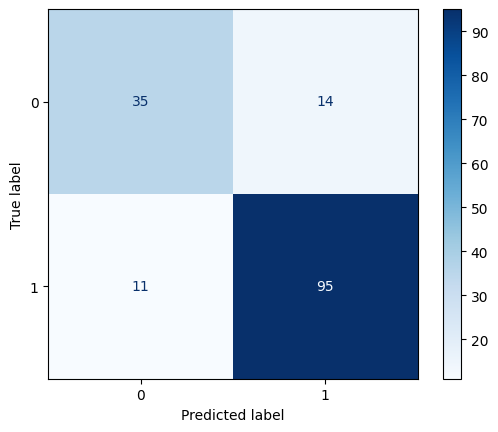

In [7]:
# Print results 
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/classifier/binary/2y_confusion_matrix')
plt.show()

# TANYAS FEATURE SET

In [5]:
# Features and target variable for training and testing sets
X_train = train_features[features_tanya]
y_train = train_features['recency']
X_test = test_features[features_tanya]
y_test = test_features['recency']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search_tanya = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search_tanya.fit(X_train, y_train)

# Get the best estimator
best_model_tanya = grid_search_tanya.best_estimator_

# Make predictions on the test set
y_pred_tanya = best_model_tanya.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred_tanya)
class_report = classification_report(y_test, y_pred_tanya)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        49
           1       0.86      0.90      0.88       106

    accuracy                           0.83       155
   macro avg       0.80      0.78      0.79       155
weighted avg       0.82      0.83      0.82       155



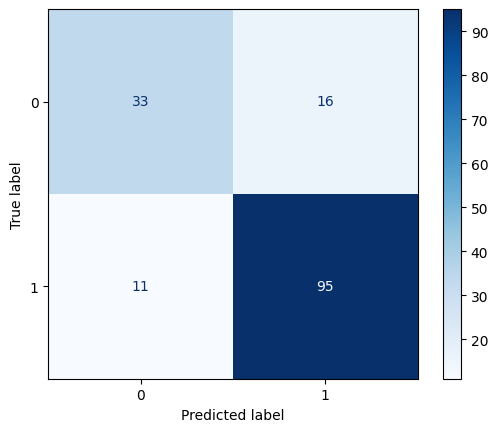

Accuracy: 0.8258064516129032


In [7]:
# Print results 
print("Best Parameters:", grid_search_tanya.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp_tanya = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model_tanya.classes_)
disp_tanya.plot(cmap=plt.cm.Blues)
plt.show()
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print('Accuracy:', accuracy_score(y_test, y_pred_tanya))

# FINDING BEST FEATURE SET

In [129]:
features_1 = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c',
                    'lrtt_coeff_1']
features_4 = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 'genome_maf12c', 'gp120_ambig', 'lrtt_coeff_1']
features_5 = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3']
features_6 = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11']
features_7 = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c']
features_8 = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3', 'genome_ambig']

In [130]:
feature_sets = {
    'RFECV1': features_derived,
    'Tanya': features_tanya,
    'Feature Set 1.0': features_1,
    'Feature Set 4.0': features_4,
    'Feature Set 5.0': features_5,
    'Feature Set 6.0': features_6,
    'Feature Set 7.0': features_7,
    'Feature Set 8.0': features_8
}

In [132]:
import time

results = []

for set_name, features in feature_sets.items():
    print(f"Running model for {set_name}")
    
    # Define X and y for training and testing sets
    X_train = train_features[features]
    y_train = train_features['recency']
    X_test = test_features[features]
    y_test = test_features['recency']

    # Initialize the GridSearchCV
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=StratifiedKFold(n_splits=5),
                               scoring='accuracy',
                               n_jobs=-1)
    
    # Measure the time taken to train the model
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Perform predictions on the test set
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    average_precision = average_precision_score(y_test, y_pred_proba)
    precision_non_recent = precision_score(y_test, y_pred, pos_label=0)
    recall_non_recent = recall_score(y_test, y_pred, pos_label=0)
    f1_non_recent = f1_score(y_test, y_pred, pos_label=0)
    precision_recent = precision_score(y_test, y_pred, pos_label=1)
    recall_recent = recall_score(y_test, y_pred, pos_label=1)
    f1_recent = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'feature_set': set_name,
        'best_params': grid_search.best_params_,
        'training_time': training_time,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        'precision_non_recent': precision_non_recent,
        'recall_non_recent': recall_non_recent,
        'f1_non_recent': f1_non_recent,
        'precision_recent': precision_recent,
        'recall_recent': recall_recent,
        'f1_recent': f1_recent
    })

Running model for RFECV1


Running model for Tanya
Running model for Feature Set 1.0
Running model for Feature Set 4.0
Running model for Feature Set 5.0
Running model for Feature Set 6.0
Running model for Feature Set 7.0
Running model for Feature Set 8.0


In [134]:
# Print the results
results_df = pd.DataFrame(results)

In [135]:
#save results
results_df.to_csv(f'{output_dir}/all_binary_model_performance_metrics.csv', index=False)

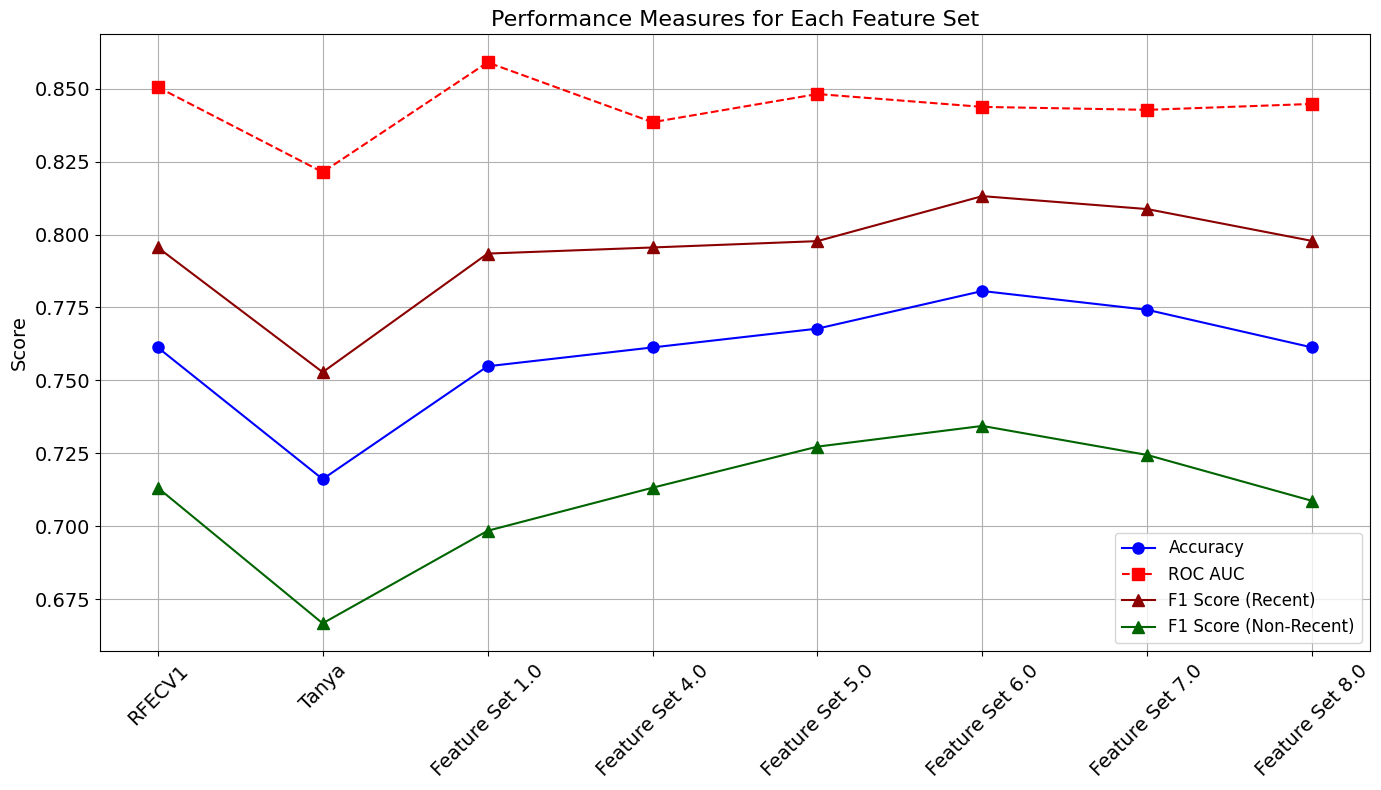

In [156]:
# Plotting accuracy and ROC AUC for each feature set
plt.figure(figsize=(14, 8))
plt.plot(results_df['feature_set'], results_df['accuracy'], marker='o', markersize = 8, linestyle='-', label='Accuracy', color='blue')
plt.plot(results_df['feature_set'], results_df['roc_auc'], marker='s', markersize = 8,linestyle='--', label='ROC AUC', color='red')
plt.plot(results_df['feature_set'], results_df['f1_recent'], marker='^', markersize = 8,linestyle='-', label='F1 Score (Recent)', color='darkred')
plt.plot(results_df['feature_set'], results_df['f1_non_recent'], marker='^', markersize = 8,linestyle='-', label='F1 Score (Non-Recent)', color='darkgreen')
plt.title('Performance Measures for Each Feature Set', size = 16)
plt.ylabel('Score', size = 14)
plt.xticks(rotation=45, size = 14)
plt.yticks(size = 14)
plt.legend(loc='best', fontsize='large', frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/features_sets_performance_comp.pdf')
plt.show()

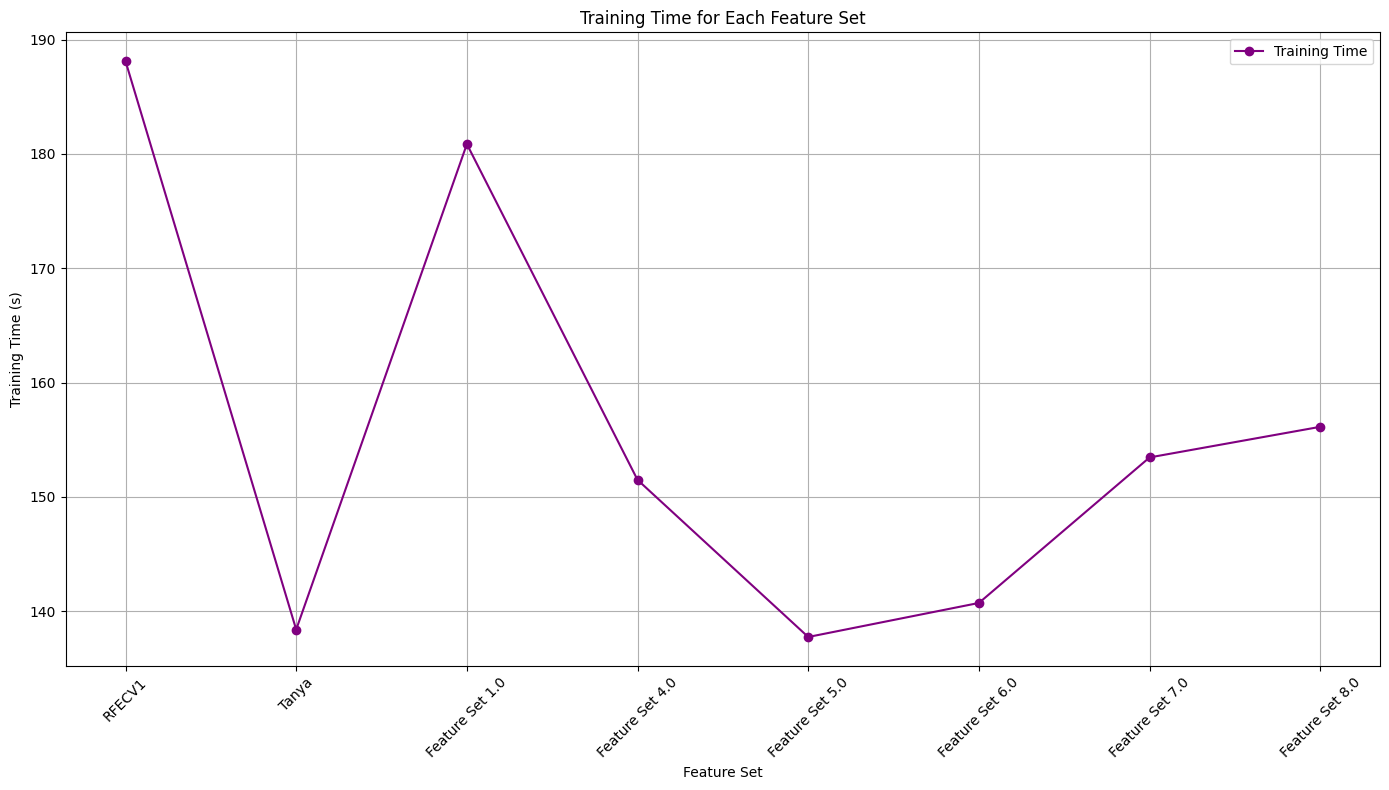

In [153]:
# Plotting Training Time for each feature set
plt.figure(figsize=(14, 8))
plt.plot(results_df['feature_set'], results_df['training_time'], marker='o', linestyle='-', label='Training Time', color='purple')
plt.title('Training Time for Each Feature Set')
plt.xlabel('Feature Set')
plt.ylabel('Training Time (s)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [162]:
results_df

,feature_set,best_params,training_time,accuracy,roc_auc,average_precision,precision_non_recent,recall_non_recent,f1_non_recent,precision_recent,recall_recent,f1_recent
0,RFECV1,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",188.109129,0.761290,0.850577,0.884279,0.741935,0.686567,0.713178,0.774194,0.818182,0.795580
1,Tanya,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",138.401747,0.716129,0.821404,0.858933,0.676923,0.656716,0.666667,0.744444,0.761364,0.752809
2,Feature Set 1.0,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",180.851516,0.754839,0.859057,0.892935,0.745763,0.656716,0.698413,0.760417,0.829545,0.793478
3,Feature Set 4.0,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",151.491371,0.761290,0.838535,0.860497,0.741935,0.686567,0.713178,0.774194,0.818182,0.795580
4,Feature Set 5.0,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",137.754916,0.767742,0.848202,0.869140,0.738462,0.716418,0.727273,0.788889,0.806818,0.797753
5,Feature Set 6.0,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",140.731640,0.780645,0.843792,0.868349,0.770492,0.701493,0.734375,0.787234,0.840909,0.813187
6,Feature Set 7.0,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",153.456038,0.774194,0.842775,0.865427,0.766667,0.686567,0.724409,0.778947,0.840909,0.808743
7,Feature Set 8.0,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",156.132997,0.761290,0.844810,0.873002,0.750000,0.671642,0.708661,0.768421,0.829545,0.797814


# FIND BEST THRESHOLD FOR RECENCY

## A - Plot distributions

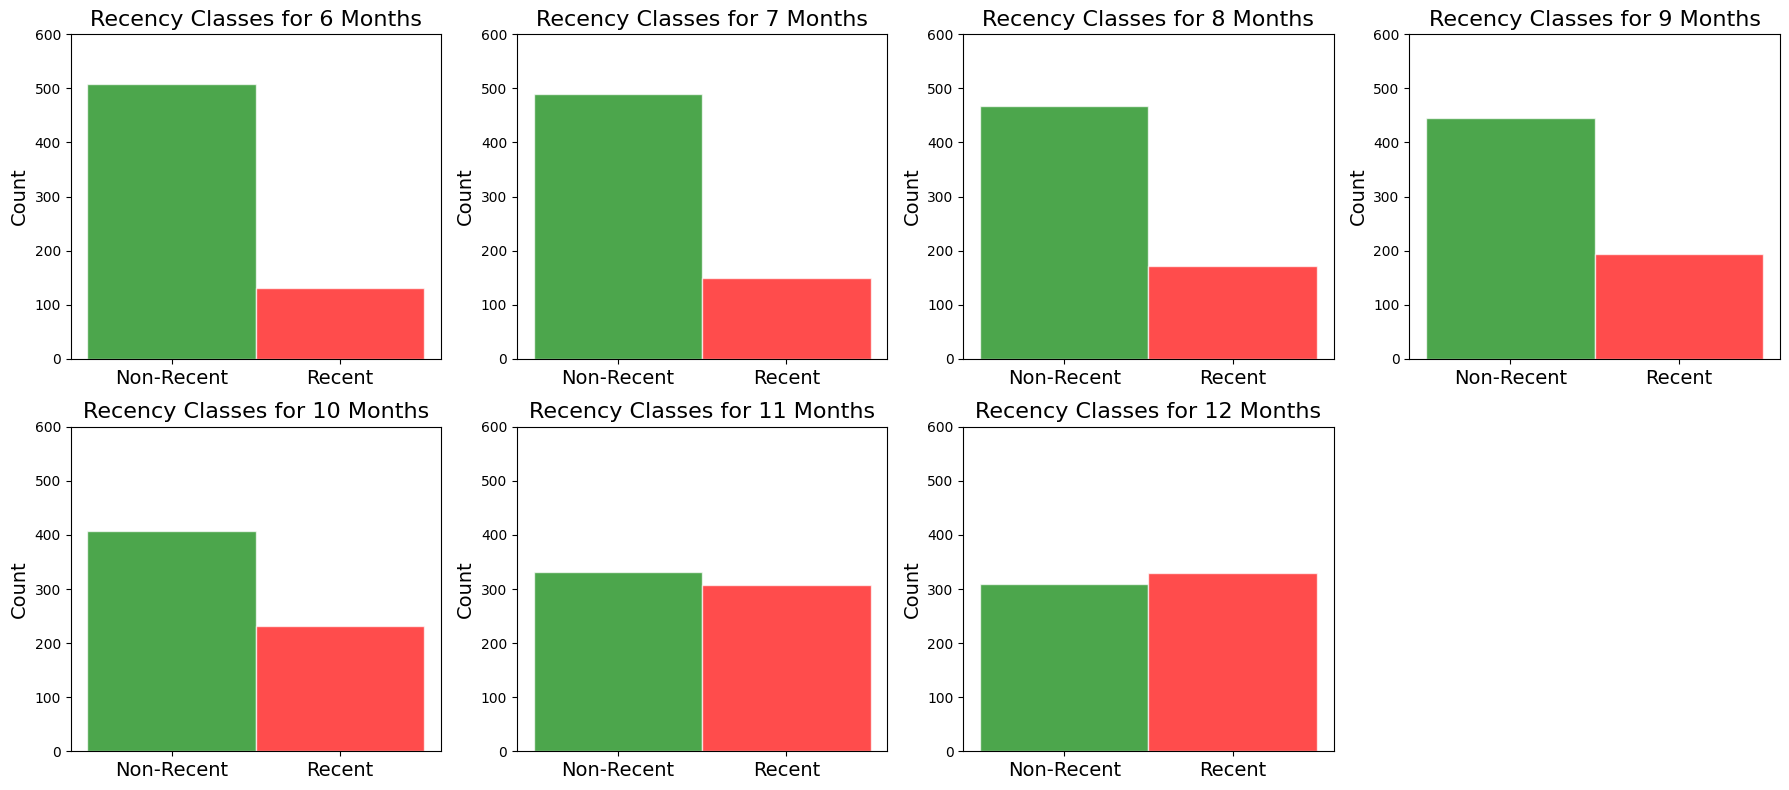

In [99]:
output_dir = './outputs/classifier/binary'

months = range(6, 13)  #recency from 6 to 12 months
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

#iterate through thresholds and plot distribution
for i, month in enumerate(months):
    #recency label
    recency_threshold = month * 30.44
    combined['recency'] = np.where(combined['TSI_days'] <= recency_threshold, 1, 0)
    
    #plot histogram
    n, bins, patches = axes[i].hist(combined['recency'], bins=2, alpha=0.7, edgecolor='white')
    for patch, color in zip(patches, ['green', 'red']):
        patch.set_facecolor(color)
    axes[i].set_ylabel('Count', size=14)
    axes[i].set_title(f'Recency Classes for {month} Months', size=16)
    axes[i].set_xticks([bins[0] + (bins[1] - bins[0]) / 2, bins[1] + (bins[2] - bins[1]) / 2])
    axes[i].set_xticklabels(['Non-Recent', 'Recent'], size=14)
    axes[i].set_ylim(0, 600)

#remove empty plots
for j in range(len(months), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig(f'{output_dir}/binary_class_distributions.pdf')
plt.show()

## B - Tune and Train at Each Threshold

In [1]:
30.44*12

365.28000000000003

Months: 6
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       131
           1       0.52      0.50      0.51        24

    accuracy                           0.85       155
   macro avg       0.72      0.71      0.71       155
weighted avg       0.85      0.85      0.85       155



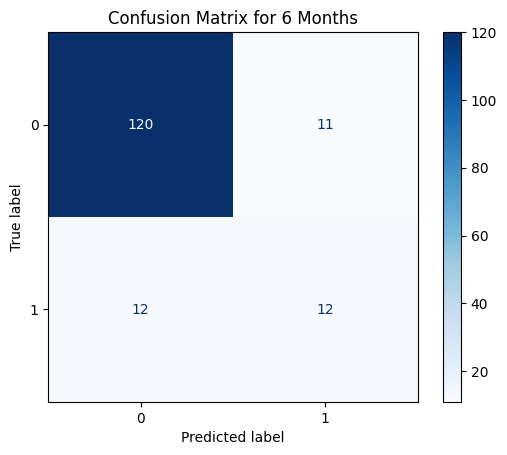

Months: 7
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       124
           1       0.64      0.68      0.66        31

    accuracy                           0.86       155
   macro avg       0.78      0.79      0.78       155
weighted avg       0.86      0.86      0.86       155



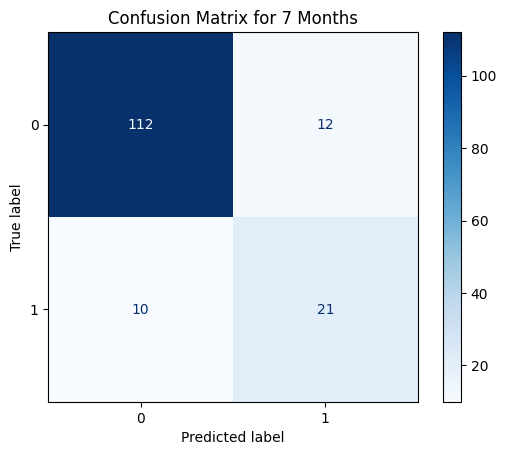

Months: 8
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       114
           1       0.72      0.63      0.68        41

    accuracy                           0.84       155
   macro avg       0.80      0.77      0.78       155
weighted avg       0.83      0.84      0.84       155



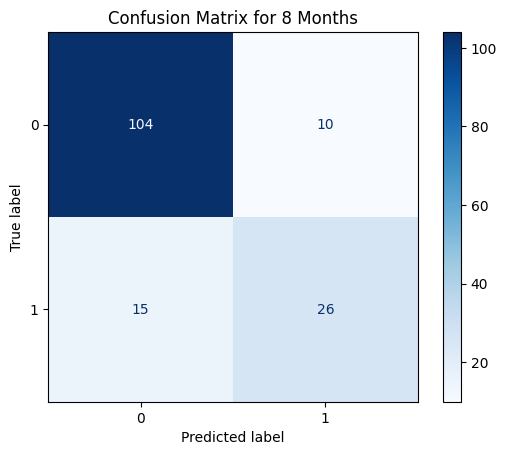

Months: 9
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       107
           1       0.67      0.58      0.62        48

    accuracy                           0.78       155
   macro avg       0.74      0.73      0.73       155
weighted avg       0.77      0.78      0.78       155



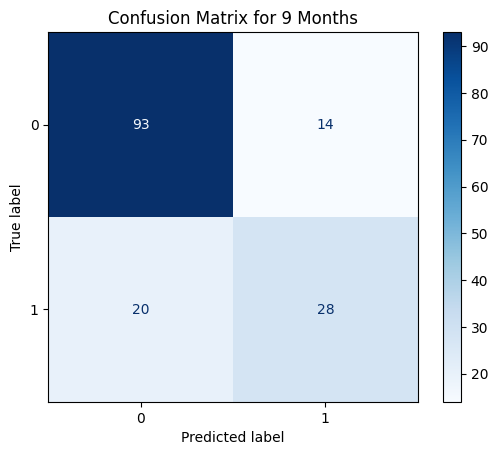

Months: 10
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       101
           1       0.63      0.70      0.67        54

    accuracy                           0.75       155
   macro avg       0.73      0.74      0.74       155
weighted avg       0.76      0.75      0.76       155



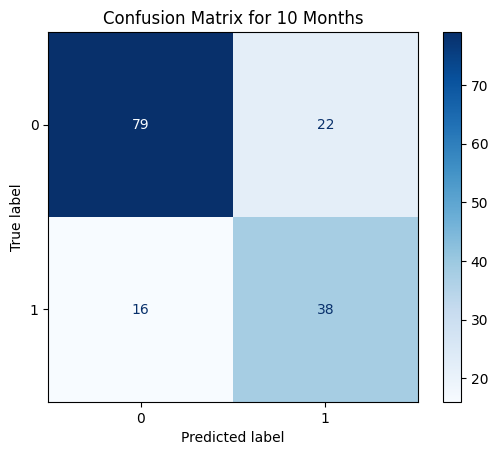

Months: 11
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68        74
           1       0.70      0.78      0.74        81

    accuracy                           0.71       155
   macro avg       0.71      0.71      0.71       155
weighted avg       0.71      0.71      0.71       155



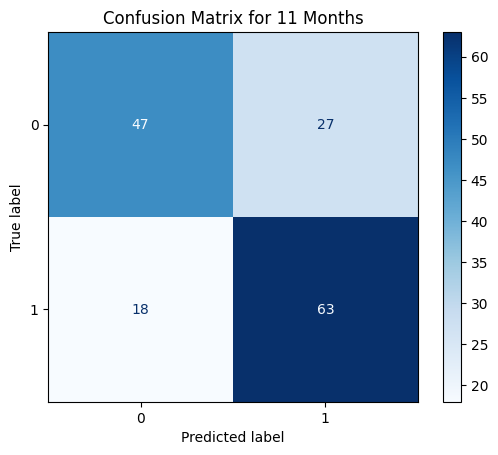

Months: 12
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        67
           1       0.77      0.82      0.80        88

    accuracy                           0.76       155
   macro avg       0.76      0.75      0.75       155
weighted avg       0.76      0.76      0.76       155



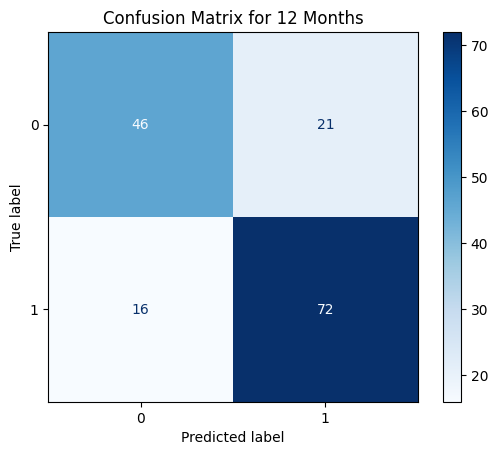

In [45]:
# Initialize lists to store results
results = []

for months in range(6, 13):
    recency_threshold = months * 30.44
    
    # Label the data
    train_features['recency'] = np.where(train_features['TSI_days'] <= recency_threshold, 1, 0)
    test_features['recency'] = np.where(test_features['TSI_days'] <= recency_threshold, 1, 0)
    combined['recency'] = np.where(combined['TSI_days'] <= recency_threshold, 1, 0)
    
    # Features and target variable for training and testing sets
    X_train = train_features[features_derived]
    y_train = train_features['recency']
    X_test = test_features[features_derived]
    y_test = test_features['recency']
    
    # Initialize and fit the GridSearchCV
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=StratifiedKFold(n_splits=5),
                               scoring='accuracy',
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model 
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results.append({
        'months': months,
        'best_params': grid_search.best_params_,
        'conf_matrix': conf_matrix.tolist(),
        'class_report': class_report,
        'y_test': y_test.tolist(),
        'y_pred_proba': best_model.predict_proba(X_test).tolist()  # Add predicted probabilities
    })
    
    # Print results for each iteration
    print(f"Months: {months}")
    print("Best Parameters:", grid_search.best_params_)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {months} Months')
    plt.savefig(f'{output_dir}/{months}_months_confusion_matrix.png')
    plt.show()

# Optionally, save the results to a file
import json
with open('./outputs/classifier/binary/results.json', 'w') as f:
    json.dump(results, f, indent=4)

## C - Plot Evaluation Metrics

In [23]:
# Extract the relevant metrics
months = [res['months'] for res in results]
accuracies = [res['class_report']['accuracy'] for res in results]
precision_0 = [res['class_report']['0']['precision'] for res in results]
recall_0 = [res['class_report']['0']['recall'] for res in results]
f1_0 = [res['class_report']['0']['f1-score'] for res in results]
precision_1 = [res['class_report']['1']['precision'] for res in results]
recall_1 = [res['class_report']['1']['recall'] for res in results]
f1_1 = [res['class_report']['1']['f1-score'] for res in results]


In [24]:
# Create a DataFrame
df_metrics = pd.DataFrame({
    'Months': months,
    'Accuracy': accuracies,
    'Precision_0': precision_0,
    'Recall_0': recall_0,
    'F1_0': f1_0,
    'Precision_1': precision_1,
    'Recall_1': recall_1,
    'F1_1': f1_1
})

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_85142/951972583.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(df_metrics['Months'], df_metrics['Recall_0'], 'd--', label='Recall (Non-Recent)', color = 'lime', linestyle = '-.')
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_85142/951972583.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df_metrics['Months'], df_metrics['Precision_1'], 's-', label='Precision (Recent)', color = 'red', linestyle = '--')
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_85142/951972583.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d--" (-> linestyle='--'). The keyword argument will take prec

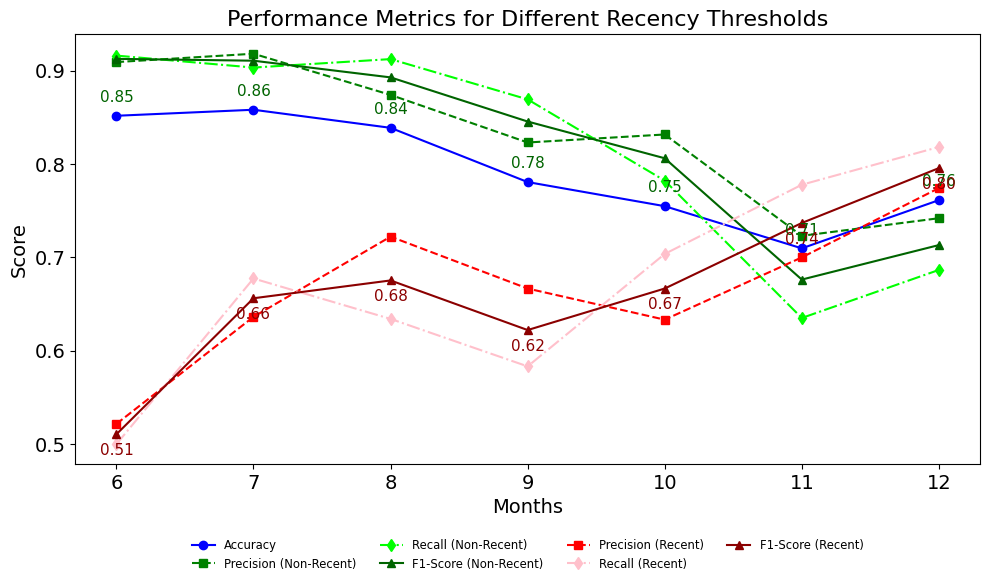

In [64]:
# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['Months'], df_metrics['Accuracy'], 'o-',label='Accuracy', color = 'blue')
plt.plot(df_metrics['Months'], df_metrics['Precision_0'],'s--', label='Precision (Non-Recent)', color='green')
plt.plot(df_metrics['Months'], df_metrics['Recall_0'], 'd--', label='Recall (Non-Recent)', color = 'lime', linestyle = '-.')
plt.plot(df_metrics['Months'], df_metrics['F1_0'], '^-', label='F1-Score (Non-Recent)', color = 'darkgreen')
plt.plot(df_metrics['Months'], df_metrics['Precision_1'], 's-', label='Precision (Recent)', color = 'red', linestyle = '--')
plt.plot(df_metrics['Months'], df_metrics['Recall_1'], 'd--', label='Recall (Recent)', color = 'pink', linestyle = '-.')
plt.plot(df_metrics['Months'], df_metrics['F1_1'], '^-', label='F1-Score (Recent)', color = 'darkred')

plt.xlabel('Months', size = 14)
plt.ylabel('Score', size = 14)
plt.title('Performance Metrics for Different Recency Thresholds', size = 16)
plt.xticks(size =14)
plt.yticks(size =14)
# Enhancing the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize='small', frameon=False)

# Annotating key points (optional)
for i, month in enumerate(df_metrics['Months']):
    plt.annotate(f'{df_metrics["F1_0"][i]:.2f}', (month, df_metrics["F1_0"][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=11, color='darkgreen')
    plt.annotate(f'{df_metrics["F1_1"][i]:.2f}', (month, df_metrics["F1_1"][i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=11, color='darkred')
plt.tight_layout()
plt.savefig(f'{output_dir}/performance_metrics_over_time.pdf')
plt.show()

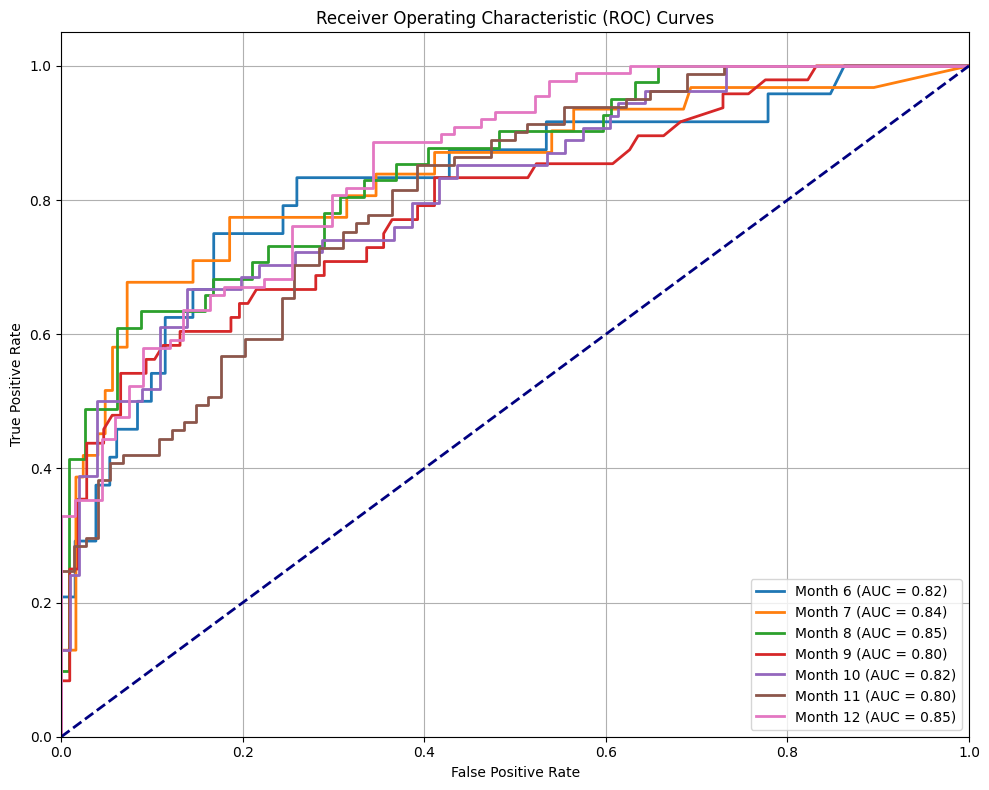

In [50]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Initialize lists to store ROC curve data
fpr_list = []
tpr_list = []
roc_auc_list = []
months2 = [res['months'] for res in results]

for res in results:
    months = res['months']
    y_test = np.array(res['y_test'])
    y_pred_proba = np.array(res['y_pred_proba'])[:, 1]  # Get probabilities for the positive class
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(months2)):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'Month {months2[i]} (AUC = {roc_auc_list[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/roc_curves.png')
plt.show()